In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.integrate import ode
from tqdm import tqdm

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The momentum equation of the spinning pizza problem is

\begin{equation}
\label{eq:momentum}
-\frac{\partial p}{\partial r} + \frac{\partial \sigma_{rr}}{\partial r}  + \frac{\sigma_{rr}-\sigma_{\theta\theta}}{r} + \rho \Omega^2 r = 0,
\end{equation}

where $\boldsymbol{\sigma}$ is the elastic stress, and $p$ the pressure. The vertical force balance in the slender limit imposes $p = \sigma_{zz}$, such that the equation \eqref{eq:momentum} reduces to 

\begin{equation}
\label{eq:momentum-v2}
 \frac{\partial (\sigma_{rr}-\sigma_{zz})}{\partial r}  + \frac{\sigma_{rr}-\sigma_{\theta\theta}}{r} + \rho \Omega^2 r = 0,
\end{equation}

We assume a *shear-free* elastic mapping, defined via the function $r(R)$, where $r$ is the current Eulerian radial position of the elastic solid and $R$ its reference Lagrangian radial position. We take a neo-Hookean formulation, such that the elastic stresses are related to the elastic mapping function via 

\begin{equation}
\label{eq:stresses}
 \frac{\sigma_{rr}}{G} = r'^2 - 1, \quad \quad  \frac{\sigma_{\theta\theta}}{G} = \frac{r^2}{R^2} - 1, \quad \quad \frac{\sigma_{zz}}{G} = \frac{h^2}{H^2} - 1 = \frac{R^2}{r^2 r'^2}-1,
\end{equation}

where prime denote derivative with respect to $R$. Injecting the constitutive relation \eqref{eq:stresses} into the momentum balance \eqref{eq:momentum-v2}, we get

\begin{equation}
 \frac{1}{r'} \left(r'^2 - \frac{R^2}{r^2 r'^2}\right)'  + \frac{1}{r}\left(r'^2 - \frac{r^2}{R^2}\right) + \frac{r}{L^2} = 0, \quad \quad L = \frac{G}{\rho \Omega^2}.
\end{equation}

Using the initial radius $R_0$ as a scale for both $r$ and $R$, we find, 

\begin{equation}
 \frac{1}{r'} \left(r'^2 - \frac{R^2}{r^2 r'^2}\right)'  + \frac{1}{r}\left(r'^2 - \frac{r^2}{R^2}\right) + \mathrm{Pi} r = 0, \quad \quad \mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}.
\end{equation}

with $\mathrm{Pi}$ the so-called pizza number. The boundary condition are $r(0) = 0$ from the axial symmetry and $r'(1)=0$ from the stress-free condition at the edge. We can expand and rearrange terms to make it in a convenient form for RK4 integration. 

\begin{equation}
 r'' \left(1 + \frac{R^2}{r^2r'^4}\right) = -\frac{\mathrm{Pi} r}{2} -\frac{1}{2r} \left(r'^2 - \frac{r^2}{R^2}\right)  - \left(\frac{R}{r^2r'^3} - \frac{R^2}{r^3r'^2}\right)
\end{equation}

In [2]:
def Matching_Condition(Pi, rp_0):
    """ Return the matching condition, i.e. r'(1) - 1 """
    dR = 0.002 # grid step
    R0 = dR # starting Lagrangian point
    y0 = [rp_0*dR , rp_0] # initial Eulerian radius and radial stretching

    def f(t, y):
        """ RK Function """
        r = y[0]
        rp = y[1]
        R = t
        return [rp, (   -Pi*r/2 - 1/(2*r)*(rp**2 - r**2/R**2) - ( R/(r**2*rp**3) - R**2/(r**3*rp**2) )   )  /   (1  + R**2/r**2/rp**4 ) ]

    RK = ode(f).set_integrator('dopri5')
    RK.set_initial_value(y0, R0)

    r_save, rp_save, R_save = [y0[0]], [y0[1]], [R0] # Saving list

    while RK.successful() and RK.t < 1.:
        A = RK.integrate(RK.t+dR)
        r_save.append(A[0])
        rp_save.append(A[1])
        R_save.append(RK.t)
        
    r = np.array(r_save)
    R = np.array(R_save)
    I = np.sum(r[:]*2*R[:]*(1-R[:]**2)*dR) # moment of inertia with drop initial condition
    return rp_save[-1] - 1., r_save[-1]  , I


def Stretching(Pi):
    """ Matching algorithm - Find the relevent central stretching with a dichotomy algorithm"""
    dich_idx = 0 # index for the dichotomy loop
    stetching_min = 0.8
    stetching_max = 100000000
    while dich_idx < 50: # 50 so that we have an accuracy ~ (1/2)^50 = detla * 10^-15
        condition, r_max, I = Matching_Condition(Pi, (stetching_min+stetching_max)/2)
        if condition > 0 :
            stetching_max = (stetching_min+stetching_max)/2
        else :
            stetching_min = (stetching_min+stetching_max)/2
        dich_idx += 1
    
    return (stetching_min+stetching_max)/2, r_max, I


def Solution(Pi, rp_0):
    """Same as before, but return the profiles. """
    dR = 0.001 # grid step
    R0 = dR # starting Lagrangian point
    y0 = [rp_0*dR , rp_0] # initial Eulerian radius and radial stretching

    def f(t, y):
        """ RK Function """
        r = y[0]
        rp = y[1]
        R = t
        return [rp, (   -Pi*r/2 - 1/(2*r)*(rp**2 - r**2/R**2) - ( R/(r**2*rp**3) - R**2/(r**3*rp**2) )   )  /   (1  + R**2/r**2/rp**4 ) ]

    RK = ode(f).set_integrator('dopri5')
    RK.set_initial_value(y0, R0)
    r_save, rp_save, R_save = [y0[0]], [y0[1]], [R0]

    while RK.successful() and RK.t < 1.:
        A = RK.integrate(RK.t+dR)
        r_save.append(A[0])
        rp_save.append(A[1])
        R_save.append(RK.t)
        
    return np.array(r_save), np.array(rp_save), np.array(R_save)

In [3]:
Pi_0 = 0
Pi_1 = 1.
Pi_2 = 2.
Pi_3 = 3.
Pi_4 = 4.

Pi_5 = 5.
Pi_6 = 5.3
Pi_7 = 5.6
Pi_8 = 5.9

Pi_9 = 6.2546

LABELS = [r'$0$', r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$5.3$', r'$5.6$', r'$5.9$', r'$6.2546$']

stetching0, r_max, I = Stretching(Pi_0)
stetching1, r_max, I = Stretching(Pi_1)
stetching2, r_max, I = Stretching(Pi_2)
stetching3, r_max, I = Stretching(Pi_3)
stetching4, r_max, I = Stretching(Pi_4)
stetching5, r_max, I = Stretching(Pi_5)
stetching6, r_max, I = Stretching(Pi_6)
stetching7, r_max, I = Stretching(Pi_7)
stetching8, r_max, I = Stretching(Pi_8)
stetching9, r_max, I = Stretching(Pi_9)

In [4]:
r0, rp0, R0 = Solution(Pi_0, stetching0) 
r1, rp1, R1 = Solution(Pi_1, stetching1) 
r2, rp2, R2 = Solution(Pi_2, stetching2) 
r3, rp3, R3 = Solution(Pi_3, stetching3) 
r4, rp4, R4 = Solution(Pi_4, stetching4)
r5, rp5, R5 = Solution(Pi_5, stetching5) 
r6, rp6, R6 = Solution(Pi_6, stetching6) 
r7, rp7, R7 = Solution(Pi_7, stetching7) 
r8, rp8, R8 = Solution(Pi_8, stetching8) 
r9, rp9, R9 = Solution(Pi_9, stetching9) 

[4.675, 1.87]


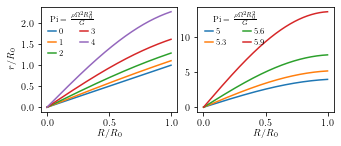

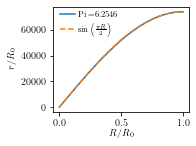

In [6]:



####### Figure parameters ######
fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.4
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)

fig = plt.figure() 

L  = 0.11
B  = 0.2
dW = 0.06
W  = (0.98 - dW-L)/2
H  = 0.98 - B



ax = fig.add_axes([L, B, W, H]) 

ax.plot(R0, r0, label = LABELS[0])
ax.plot(R1, r1, label = LABELS[1])
ax.plot(R2, r2, label = LABELS[2])
ax.plot(R3, r3, label = LABELS[3])
ax.plot(R4, r4, label = LABELS[4])
ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(R5, r5, label = LABELS[5])
ax.plot(R6, r6, label = LABELS[6])
ax.plot(R7, r7, label = LABELS[7])
ax.plot(R8, r8, label = LABELS[8])
#ax.plot(R9, r9, label = LABELS[9])
#ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)
plt.savefig('Pizza.pdf')



[4.675, 1.87]


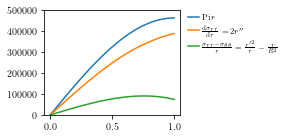

In [7]:
# -Pi*r/2 - 1/(2*r)*(rp**2 - r**2/R**2) - ( R/(r**2*rp**3) - R**2/(r**3*rp**2) )   )

####### Figure parameters ######
fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.4
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)

fig = plt.figure() 
ax = fig.add_axes([L+0.1, B, W, H]) 

dR_plot = R9[1]-R9[0]

ddr9 = (r9[2:]-2*r9[1:-1]+r9[:-2])/dR_plot**2

dr9_test = (r9[1:]-r9[:-1])/(R9[1:]-R9[:-1])
ddr9_bis = (rp9[1:]-rp9[:-1])/(R9[1:]-R9[:-1])


ax.plot(R9, Pi_9*r9 , label = r'$\mathrm{Pi} \, r$')
ax.plot(R9[1:-1], -2*ddr9 , label = r'$\frac{\mathrm{d}\sigma_{rr}}{\mathrm{d}r} = 2 r^{\prime\prime}$')
ax.plot(R9,  -1/(r9)*(rp9**2 -r9**2/R9**2) , label = r'$\frac{\sigma_{rr}-\sigma_{\theta\theta}}{r} = \frac{r^{\prime 2}}{r} - \frac{r}{R^2}$')
#ax.plot(R9,  1/(r9)*(), label = r'$\frac{\sigma_{\theta\theta}}{r} = \frac{r}{R^2}$' )
#ax.plot(R9, -Pi_9*r9/2 - 1/(2*r9)*(rp9**2 - r9**2/R9**2), '--')
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.4)
ax.set_ylim(0, 500000)
#ax.set_yscale('log')
plt.savefig('terms.pdf', bbox_inches = 'tight')

In [8]:
N_plot = 100
Pi_c = 6.25467
Log_axis = np.logspace(-5,0, N_plot)

Pi_plot = Pi_c - Log_axis



STRETCH, RMAX, Inertia = np.zeros(N_plot), np.zeros(N_plot), np.zeros(N_plot)
#for i in range(N_plot):
for i in tqdm(range(N_plot)):
    STRETCH[i], RMAX[i], Inertia[i] = Stretching(Pi_plot[i])

100%|█████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


[4.675, 1.87]


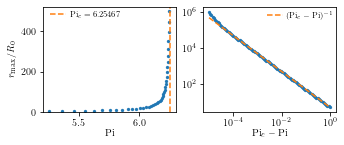

In [9]:
####### Figure parameters ######
fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.4
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)
fig = plt.figure() 

L  = 0.11
B  = 0.2
dW = 0.08
W  = (0.98 - dW-L)/2
H  = 0.98 - B

Pi_c = 6.25467

ax = fig.add_axes([L, B, W, H]) 

ax.plot(Pi_plot, RMAX, 'o', markersize = 3, markeredgewidth=0.3)
ax.plot([Pi_c, Pi_c], [0, RMAX[0]], '--', label = r'$\mathrm{Pi}_c = 6.25467$')
ax.set_ylim(0, 520)
ax.set_ylabel(r'$r_\mathrm{max}/R_0$')
ax.set_xlabel(r'$\mathrm{Pi}$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 2.0)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(Pi_c-Pi_plot, RMAX, 'o', markersize = 3, markeredgewidth=0.3)
ax.plot(Pi_c-Pi_plot, 5*(Pi_c-Pi_plot)**(-1), '--', label = r'$(\mathrm{Pi}_c-\mathrm{Pi})^{-1}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\mathrm{Pi}_c-\mathrm{Pi}$', labelpad = 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 2.0)
plt.savefig('Criticality.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4.675, 1.87]


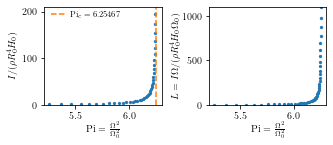

In [10]:
####### Figure parameters ######
fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.4
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)
fig = plt.figure() 
L  = 0.14
B  = 0.25
dW = 0.14
W  = (0.98 - dW-L)/2
H  = 0.98 - B

Pi_c = 6.25467
ax = fig.add_axes([L, B, W, H]) 

ax.plot(Pi_plot, Inertia, 'o', markersize = 3, markeredgewidth=0.3)
ax.plot([Pi_c, Pi_c], [0, Inertia[0]], '--', label = r'$\mathrm{Pi}_c = 6.25467$')
ax.set_ylim(0, 210)
ax.set_ylabel(r'$I / (\rho R_0^4 H_0)$')
ax.set_xlabel(r'$\mathrm{Pi} = \frac{\Omega^2}{\Omega_0^2}$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 2.0)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(Pi_plot, Inertia*np.sqrt(Pi_plot), 'o', markersize = 3, markeredgewidth=0.3)
ax.set_ylim(0, 1100)
ax.set_xlabel(r'$\mathrm{Pi} = \frac{\Omega^2}{\Omega_0^2}$', labelpad = 1)
ax.set_ylabel(r'$L = I\Omega / (\rho R_0^4 H_0\Omega_0)$', labelpad = 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 2.0)
plt.savefig('MomentInertia.pdf')

[4.675, 3.74]


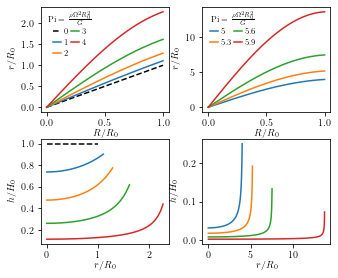

In [13]:
h0 = R0/(r0*rp0)
h1 = R1/(r1*rp1)
h2 = R2/(r2*rp2)
h3 = R3/(r3*rp3)
h4 = R4/(r4*rp4)
h5 = R5/(r5*rp5)
h6 = R6/(r6*rp6)
h7 = R7/(r7*rp7)
h8 = R8/(r8*rp8)


fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.8
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)

fig = plt.figure() 

L  = 0.12
B  = 0.1
dW = 0.1
dH = 0.1
W  = (0.98 - dW-L)/2
H  = (0.98 - B - dH) / 2



ax = fig.add_axes([L, B+dH+H, W, H]) 

ax.plot(R0, r0, label = LABELS[0], color = 'black', linestyle = 'dashed')
ax.plot(R1, r1, label = LABELS[1])
ax.plot(R2, r2, label = LABELS[2])
ax.plot(R3, r3, label = LABELS[3])
ax.plot(R4, r4, label = LABELS[4])
ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, columnspacing=0.3, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)

ax = fig.add_axes([L+W+dW, B+dH+H, W, H]) 
ax.plot(R5, r5, label = LABELS[5])
ax.plot(R6, r6, label = LABELS[6])
ax.plot(R7, r7, label = LABELS[7])
ax.plot(R8, r8, label = LABELS[8])
#ax.plot(R9, r9, label = LABELS[9])
ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, columnspacing=0.3, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)



ax = fig.add_axes([L, B, W, H]) 

ax.plot(r0, h0, label = LABELS[0], color = 'black', linestyle = 'dashed')
ax.plot(r1, h1, label = LABELS[1])
ax.plot(r2, h2, label = LABELS[2])
ax.plot(r3, h3, label = LABELS[3])
ax.plot(r4, h4, label = LABELS[4])
ax.set_ylabel(r'$h/H_0$')
ax.set_xlabel(r'$r/R_0$', labelpad = 1)
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(r5, h5, label = LABELS[5])
ax.plot(r6, h6, label = LABELS[6])
ax.plot(r7, h7, label = LABELS[7])
ax.plot(r8, h8, label = LABELS[8])
#ax.plot(R9, r9, label = LABELS[9])
ax.set_ylabel(r'$h/H_0$')
ax.set_xlabel(r'$r/R_0$', labelpad = 1)
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)
plt.savefig('Pizza_V2.pdf')


[4.675, 3.74]


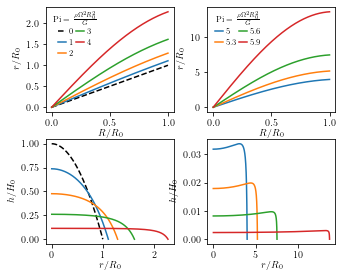

In [16]:
h0 = R0/(r0*rp0)*(1-R0**2)
h1 = R1/(r1*rp1)*(1-R0**2)
h2 = R2/(r2*rp2)*(1-R0**2)
h3 = R3/(r3*rp3)*(1-R0**2)
h4 = R4/(r4*rp4)*(1-R0**2)
h5 = R5/(r5*rp5)*(1-R0**2)
h6 = R6/(r6*rp6)*(1-R0**2)
h7 = R7/(r7*rp7)*(1-R0**2)
h8 = R8/(r8*rp8)*(1-R0**2)


fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.8
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)

fig = plt.figure() 

L  = 0.12
B  = 0.1
dW = 0.1
dH = 0.1
W  = (0.98 - dW-L)/2
H  = (0.98 - B - dH) / 2



ax = fig.add_axes([L, B+dH+H, W, H]) 

ax.plot(R0, r0, label = LABELS[0], color = 'black', linestyle = 'dashed')
ax.plot(R1, r1, label = LABELS[1])
ax.plot(R2, r2, label = LABELS[2])
ax.plot(R3, r3, label = LABELS[3])
ax.plot(R4, r4, label = LABELS[4])
ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, columnspacing=0.3, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)

ax = fig.add_axes([L+W+dW, B+dH+H, W, H]) 
ax.plot(R5, r5, label = LABELS[5])
ax.plot(R6, r6, label = LABELS[6])
ax.plot(R7, r7, label = LABELS[7])
ax.plot(R8, r8, label = LABELS[8])
#ax.plot(R9, r9, label = LABELS[9])
ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, columnspacing=0.3, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)



ax = fig.add_axes([L, B, W, H]) 

ax.plot(r0, h0, label = LABELS[0], color = 'black', linestyle = 'dashed')
ax.plot(r1, h1, label = LABELS[1])
ax.plot(r2, h2, label = LABELS[2])
ax.plot(r3, h3, label = LABELS[3])
ax.plot(r4, h4, label = LABELS[4])
ax.set_ylabel(r'$h/H_0$')
ax.set_xlabel(r'$r/R_0$', labelpad = 1)
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(r5, h5, label = LABELS[5])
ax.plot(r6, h6, label = LABELS[6])
ax.plot(r7, h7, label = LABELS[7])
ax.plot(r8, h8, label = LABELS[8])
#ax.plot(R9, r9, label = LABELS[9])
ax.set_ylabel(r'$h/H_0$')
ax.set_xlabel(r'$r/R_0$', labelpad = 1)
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.0, ncol = 2, title = r'$\mathrm{Pi} = \frac{\rho \Omega^2 R_0^2}{G}$', title_fontsize = 8)
plt.savefig('Pizza_V3.pdf')


[4.675, 1.87]


<Figure size 336.6x134.64 with 0 Axes>

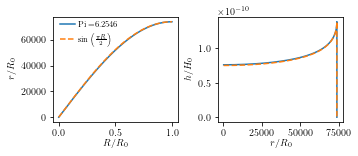

In [17]:
h9 = R9/(r9*rp9)*(1-R9**2)


fig_width_pt = 340.0        # Get this from LaTeX using \the\columnwidth --> 246/510 are the values for double/single column APS template
inches_per_pt = 1.0/72.               # Convert pt to inch
columnwidth = 0.99                    # width of the figure in columnwidth unit
fig_width = fig_width_pt*inches_per_pt*columnwidth  # width in inches
aspect_ratio = 0.4
fig_height = fig_width*aspect_ratio      # height in inches
fig_size =  [fig_width,fig_height]
print(fig_size)
font_size = 10
params = {#'backend': 'ps',
          #'figure.facecolor':'bisque',
          #'axes.facecolor':'palegreen',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          #'font.family': 'Times', #<--- here we use the new google font
          'figure.figsize': fig_size}
plt.rcParams.update(params)

fig = plt.figure() 

L  = 0.12
B  = 0.2
dW = 0.12
#dH = 0.1
W  = (0.98 - dW-L)/2
H  = (0.98 - B ) 



fig = plt.figure() 
ax = fig.add_axes([L, B, W, H]) 

ax.plot(R9, r9, label = r'$\mathrm{Pi} =$'+LABELS[9])
ax.plot(R9, r9[-1]*np.sin(R9*np.pi/2), '--', label = r'$\mathrm{sin}\left(\frac{\pi R}{2}\right)$')

ax.set_ylabel(r'$r/R_0$')
ax.set_xlabel(r'$R/R_0$', labelpad = 1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.03), frameon=False, fontsize = 8, handletextpad = 0.4, handlelength = 1.8)

ax = fig.add_axes([L+W+dW, B, W, H]) 
ax.plot(r9, h9, label = r'$\mathrm{Pi} =$'+LABELS[9])
ax.plot(r9, R9/(r9[-1]*np.sin(R9*np.pi/2)*rp9)*(1-R9**2), '--', label = r'$\mathrm{sin}\left(\frac{\pi R}{2}\right)$')

ax.set_ylabel(r'$h/H_0$')
ax.set_xlabel(r'$r/R_0$', labelpad = 1)

plt.savefig('Pizza_near_critical_point_V2.pdf', bbox_inches = 'tight')